# An approach based on FastAI

In [1]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from fastai.imports import *
from fastai.tabular.all import *
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

from sklearn.impute import SimpleImputer
from scipy import stats
import datetime
# increase the number of columns shown on screen
np.set_printoptions(linewidth=140)

### Convert the tables to fit the models

In [2]:
# Define a function that calculates the age in years
def calculate_age(birth_date):
  try:
    return (datetime.datetime.now() - birth_date).days // 365
  except Exception:
    return 0

# Define a function that calculates the age in years
def days_sense_test(test_date):
  try:
    return (datetime.datetime.now() - test_date).days
  except Exception:
    return 0

def kp_label(row):
    labels = [float(label) for label in row.split('-')]
    try:
        return (labels[0] + labels[1]) / 2
    except Exception:
        return labels[0]

Convert strings to numerical

In [3]:
annotations_dir = '../../dataset/US_liver_data/annotations/Liver_Elastography_annotations_Sheba.xlsx'
df = pd.read_excel(annotations_dir)
# check the number of nans in each column
print(f"the number of NaN scores are: {df.isnull().sum()}")

df.rename(columns={'טבלת המרה': 'Conversion', 'fibrosis score': 'label', 'birthdate': 'age'}, inplace=True)
df.drop(columns=['underlying conditions', 'Conversion', 'deceased'], inplace=True)
# filter out all unlabeled data
df = df[~df['label'].isnull() & ~(df['label']=='technical problem')]
df['label'] = df['label'].astype(str)

df['Kilopascal'] = df['Kilopascal'].astype(str)
df['Kilopascal'] = df['Kilopascal'].apply(kp_label)
# Remove kilopascal outliers using z-score
z1 = np.abs(stats.zscore(df['Kilopascal'], nan_policy='omit'))
df = df[z1 < 3]
df['Kilopascal'].fillna(value=0, inplace=True)
df['Accession_number'] = df['Accession_number'].astype(int)
# Apply the function to the 'birth_date' column
df['age'] = df['age'].apply(calculate_age)
df['Elastography Date'] = df['Elastography Date'].apply(days_sense_test)
df['liver biopsy'] = df['liver biopsy'].apply(days_sense_test)
# Remove birthdate outliers using z-score
z = np.abs(stats.zscore(df['age'], nan_policy='omit'))
df = df[z < 3]
# fill in the missing values with the mean
columns = ['BMI', 'age', 'Elastography Date', 'liver biopsy']
imputer = SimpleImputer(strategy='mean')
# Fit the imputer to the selected columns
df_selected = df.loc[:, columns]
imputer.fit(df_selected)
# Transform the selected columns to fill missing values and assign the result to the original DataFrame
df.loc[:, columns] = imputer.transform(df_selected)

df.head()

the number of NaN scores are: Accession_number            0
Elastography Date           0
טבלת המרה                   0
gender                    960
birthdate                 862
BMI                       892
fibrosis score            862
Kilopascal                868
liver biopsy             1072
underlying conditions    1086
deceased                 1093
dtype: int64


,Accession_number,Elastography Date,gender,age,BMI,label,Kilopascal,liver biopsy
0,4015009301008,1139.0,NaN,78.0,35.050,2,7.75,0.0
1,4015007487057,2203.0,NaN,73.0,26.446,0,6.05,0.0
2,4015008849573,1384.0,NaN,73.0,26.446,0,5.85,0.0
3,4015010341175,586.0,NaN,73.0,26.446,0,8.50,0.0
4,4015010798265,376.0,NaN,72.0,34.964,3,11.15,0.0


In [4]:
df.describe()

,Accession_number,Elastography Date,age,BMI,Kilopascal,liver biopsy
count,2.230000e+02,223.000000,223.000000,223.000000,223.000000,223.000000
mean,4.015009e+12,1345.286996,66.995516,29.340546,9.154484,149.044843
std,1.345920e+06,778.057791,10.658709,4.259264,7.901387,552.581222
min,4.015005e+12,187.000000,0.000000,17.147000,3.700000,0.000000
25%,4.015008e+12,670.000000,57.000000,26.601000,5.275000,0.000000
50%,4.015009e+12,1279.000000,69.000000,29.340546,6.750000,0.000000
75%,4.015010e+12,1805.000000,75.000000,31.363500,9.925000,0.000000
max,4.015011e+12,3694.000000,86.000000,44.920000,84.250000,3843.000000


In [5]:
df.describe(include=[object])

,gender,label
count,132,223
unique,2,9
top,m,0
freq,68,98


Convert to FastAI dataset

In [6]:
dep_var = 'label'
procs = [Categorify, FillMissing]
# split train and test to 70-30
splits = RandomSplitter(valid_pct=0.3)(range_of(df))
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
#hide_output
to.show(5)

,gender,Accession_number,Elastography Date,age,BMI,Kilopascal,liver biopsy,label
188,m,4015010032596,740.0,37.0,24.768000,4.75,0.0,0
156,m,4015008482371,1587.0,55.0,30.739000,11.50,0.0,3-4
152,f,4015008885942,1363.0,57.0,28.673000,4.50,0.0,0
115,f,4015007545516,2168.0,67.0,22.959000,7.75,0.0,2
85,#na#,4015008822807,1398.0,71.0,39.301998,23.00,0.0,4


## First step, use use XGBoost and random forests only on the table

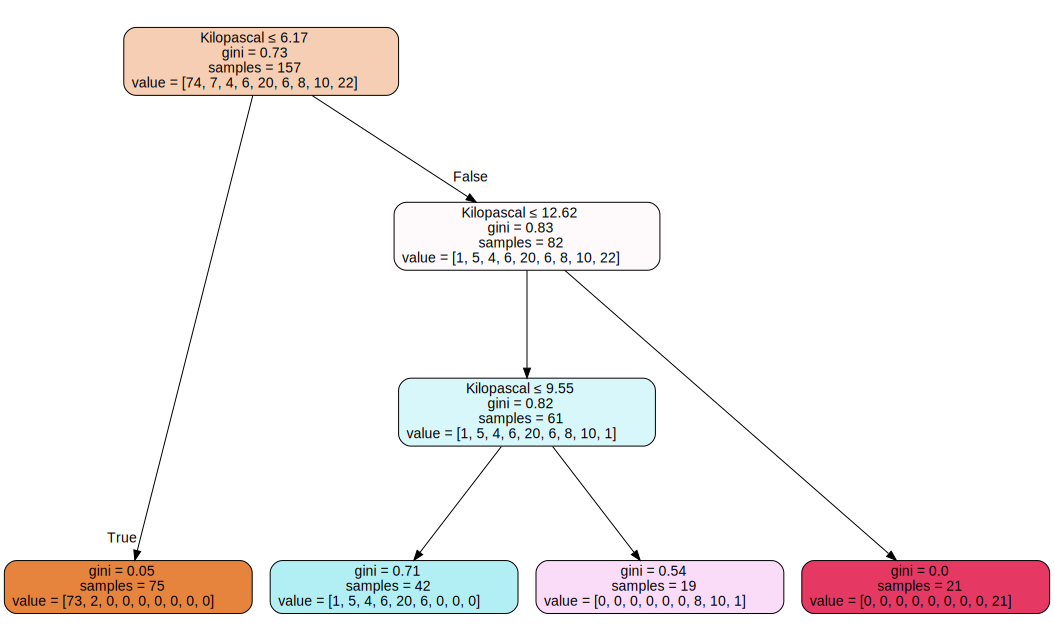

In [7]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y)
draw_tree(m, xs, size=100, leaves_parallel=True, precision=2)

<AxesSubplot: ylabel='cols'>

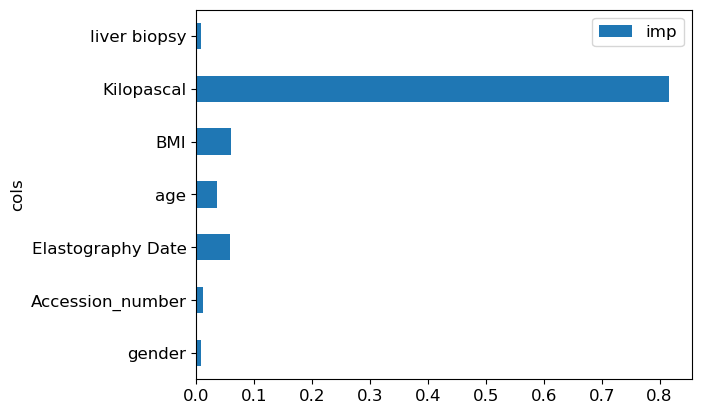

In [8]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeClassifier().fit(xs, y)
pd.DataFrame(dict(cols=xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh')

## Second step, use images to predict KiloPascal, which is the most contributing factor